## target
task : img classification

data : MNIST

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
    
import matplotlib.pyplot as plt

In [2]:
# Hyper parameters
EPOCH = 1
BATCH_SIZE = 100
LR = 0.01
DOWNLOAD_MNIST = False # 請求下載

## train data

In [3]:
# download data
train_data = torchvision.datasets.MNIST(
    root = './mnist',
    train=True, # is training data
    transform=torchvision.transforms.ToTensor(), # trans from numpy.ary to torch Tensor
    download = DOWNLOAD_MNIST,
)

torch.Size([60000, 28, 28])
torch.Size([60000])


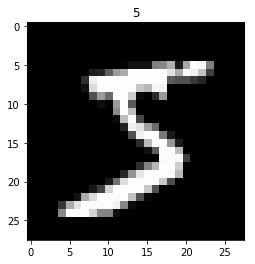

In [4]:
#plot one example
print(train_data.train_data.size())
print(train_data.train_labels.size())

plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [5]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# test data

In [6]:
test_data = torchvision.datasets.MNIST(root='./mnist', train=False)
len(test_data)

10000

In [18]:
test_data.test_data.shape

torch.Size([10000, 28, 28])

In [7]:
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1), volatile=True).type(torch.FloatTensor)
test_x = test_x[:2000]/255.

test_y = test_data.test_labels[:2000]

In [16]:
test_x.size()

torch.Size([2000, 1, 28, 28])

## build CNN

In [8]:
class CNN(nn.Module):
    def __init__(self, n_conv1_filter, n_conv2_filter):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(# input size(1,28,28)
            nn.Conv2d( 
                in_channels = 1, # gray(if RGB, then in_channel=3)
                out_channels = n_conv1_filter, # num_filter
                kernel_size=5, # filter's height and width = 5
                stride=1, # shift 1 distance each time
                padding=2, # if stride=1, padding=(kernel_size-1)/2, filled with zero
            ),# -->(16, 28, 28)
            nn.ReLU(),# -->(16, 28, 28)
            nn.MaxPool2d(kernel_size=2,),# -->(16, 14, 14)
        )
        self.conv2 = nn.Sequential(# input size(16,14,14)
            nn.Conv2d(n_conv1_filter, n_conv2_filter, 5, 1, 2), #(in, out, kernel, strid, padding) # -->(32, 14, 14)
            nn.ReLU(),# -->(32, 14, 14)
            nn.MaxPool2d(2), # -->(32, 7, 7)
        )
        self.out = nn.Linear(n_conv2_filter * 7 * 7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x) # (batch, 32, 7, 7)
        x = x.view(x.size(0), -1) #(batch, 32*7*7)
        output = self.out(x)
        return output

In [9]:
result = {}

result['param_num'] = []
result['train_acc'] = []
result['test_acc'] = []
result['train_loss'] = []
result['test_loss'] = []

In [12]:
# training and validate 20 different model

for itr in range(17, 21, 1):

    num_filter = itr * 2 + 4
    
    # declare CNN model with num_filter
    cnn=CNN(n_conv1_filter = num_filter, n_conv2_filter = (num_filter*2))
#     print(cnn)

    # count parameters number
    param_num = 0

    for parameter in cnn.parameters(): # find each layer's parameter tensor
        param_each_layer = 1
        for dim in list(parameter.size()): # calculate parameter number
            param_each_layer *=dim

        param_num += param_each_layer # sum

    print('itr %d | param_num %d'% (itr, param_num)) # finally get number of parameters
    
    def training():
        optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
        loss_func = nn.CrossEntropyLoss()

        for epoch in range(EPOCH):
            for step, (x, y) in enumerate(train_loader):
                b_x = Variable(x, requires_grad=True) # batch x
                b_y = Variable(y) # batch y

                output = cnn(b_x)
                loss = loss_func(output, b_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
#                 if step % 10 ==0:
#                 print('sucess')

        ### train
        # train_loss
        train_loss = loss.data[0]
        # train_acc
        train_x = Variable(torch.unsqueeze(train_data.train_data, dim=1), volatile=True).type(torch.FloatTensor)/255.
        train_prediction = cnn.forward(train_x)
        train_pred = torch.max(train_prediction, 1)[1].data.squeeze()
        train_y = train_data.train_labels
        train_acc = sum(train_pred ==train_y)/ train_y.size(0)

        ### test
        test_pred = cnn.forward(test_x)

        # test_loss
        test_loss = loss_func(test_pred, Variable(test_y)).data[0]
        # test_acc
        test_pred = torch.max(test_pred, 1)[1].data.squeeze()
        test_acc = sum(test_pred ==test_y)/ test_y.size(0)
        
        ### record
        result['param_num'].append(round(param_num, 4))
        result['train_acc'].append(round(train_acc, 4))
        result['test_acc'].append(round(test_acc, 4))
        result['train_loss'].append(round(train_loss, 4))
        result['test_loss'].append(round(test_loss, 4))
        
        ### print
        print(
            'train_acc : %.4f' % train_acc,
            '\t test_acc : %.4f' % test_acc,
            '\t train_loss : %.4f' % train_loss,
            '\t test_loss : %.4f' % test_loss,
        )
        
#         del cnn
        
    training()

itr 17 | param_num 110514
train_acc : 0.9791 	 test_acc : 0.9705 	 train_loss : 0.2099 	 test_loss : 0.0812
itr 18 | param_num 120330
train_acc : 0.9809 	 test_acc : 0.9740 	 train_loss : 0.0303 	 test_loss : 0.0877
itr 19 | param_num 130546
train_acc : 0.9516 	 test_acc : 0.9490 	 train_loss : 0.1648 	 test_loss : 0.1893
itr 20 | param_num 141162
train_acc : 0.9733 	 test_acc : 0.9700 	 train_loss : 0.1004 	 test_loss : 0.0848


In [13]:
result

{'param_num': [7858,
  11274,
  15090,
  19306,
  23922,
  28938,
  34354,
  40170,
  46386,
  53002,
  60018,
  67434,
  75250,
  83466,
  92082,
  101098,
  110514,
  120330,
  130546,
  141162],
 'test_acc': [0.9745,
  0.9795,
  0.974,
  0.931,
  0.9745,
  0.9715,
  0.9765,
  0.968,
  0.9635,
  0.9775,
  0.965,
  0.9725,
  0.9655,
  0.9775,
  0.9635,
  0.9735,
  0.9705,
  0.974,
  0.949,
  0.97],
 'test_loss': [0.0714,
  0.0611,
  0.0719,
  0.2072,
  0.0761,
  0.0886,
  0.0873,
  0.1001,
  0.1122,
  0.0768,
  0.0978,
  0.0876,
  0.1019,
  0.0733,
  0.1234,
  0.0868,
  0.0812,
  0.0877,
  0.1893,
  0.0848],
 'train_acc': [0.9829,
  0.9853,
  0.9836,
  0.9518,
  0.9808,
  0.9764,
  0.9808,
  0.9759,
  0.9719,
  0.983,
  0.9726,
  0.9779,
  0.9757,
  0.9819,
  0.9696,
  0.9802,
  0.9791,
  0.9809,
  0.9516,
  0.9733],
 'train_loss': [0.033,
  0.0628,
  0.0415,
  0.1551,
  0.0695,
  0.0347,
  0.1574,
  0.1035,
  0.0174,
  0.0252,
  0.1023,
  0.0348,
  0.0257,
  0.091,
  0.1396,
  0.063,

In [15]:
import pickle
with open('./output/result_MNIST_dict.pkl', 'wb') as file:
    pickle.dump(result, file)